# Experiment 001

When we switched from collecting data in sequences of 2 to sequences of 3, the model training became unstable, even though there had been no change to the model's architecture or training process. In the training process we even discarded the first board in sequences of 3, thereby treating them as sequences of 2. Let's investigate why the instability is happening.

### How often does the problem happen?

I ran the training notebook five times and every time there was some instability of varying degrees (as measured by the board accuracy spiking up and down).

### Did this problem occur with the old data and I just didn't notice it?

I ran the training notebook five times with the old data after fishing it out of my Recycle Bin and there was insability on all the runs. For some reason, the worst instability from this dataset wasn't as bad as the worst instability seen for the new dataset. Maybe this was due to chance.

Still, since the problem existed before the dataset change, there's not much point analysing the difference between the datasets. We should focus on solving the instability.

### Possible explanations

* Learning rate is too large so the model overshoots the optimum
* Batch normalization is needed to even out the distribution of hidden unit activations

# Learning rate

In [1]:
import os
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np

In [2]:
class RecordingDataset(Dataset):
    def __init__(self, path: str):
        self.path = path
        if not os.path.exists(path):
            raise FileNotFoundError()
        with os.scandir(self.path) as it:
            entry: os.DirEntry = next(iter(it))
            _, self.ext = os.path.splitext(entry.name)
            self.highest_index = max((int(Path(file.path).stem) for file in it))

    def __len__(self):
        return self.highest_index

    def __getitem__(self, idx):
        file = os.path.join(self.path, f"{idx+1}{self.ext}")
        if not os.path.exists(file):
            raise IndexError()
        boards = np.load(file)
        x = torch.tensor(boards[-2]) # Ignore all boards except the last two
        y = torch.tensor(boards[-1], dtype=torch.long)
        return x, y
        

In [16]:
dataset = RecordingDataset("data")
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

x, y = next(iter(dataloader))
print(x.shape, x.dtype)
print(y.shape, y.dtype)

torch.Size([4, 22, 10]) torch.int32
torch.Size([4, 22, 10]) torch.int64


In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
class TetrisModel(nn.Module):
    """Predicts the next state of the cells.

    Inputs:
        x: Tensor of int32 of shape (batch_size, height, width). height = 22 and width = 10 are the dimensions of the game
           board. The entries should be 0 for empty cells and 1 for blocks.
    
    Returns: Tensor of float32 of shape (batch_size, height, width), logits for the new cells. Probabilities close to 0 (negative logits)
             correspond to empty cells, and probabilities close to 1 (positive logits) correspond to blocks.
    """

    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 10, 3)
        self.conv1 = nn.Conv2d(10, 10, 3)
        self.conv2 = nn.Conv2d(10, 10, 1)
        self.conv3 = nn.Conv2d(10, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = F.relu(self.conv0(F.pad(x, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x = F.relu(self.conv1(F.pad(x, (1, 1, 1, 1))))
        x = F.relu(self.conv2(x))
        logits = F.log_softmax(self.conv3(x), dim=1)
        return logits

In [6]:
model = TetrisModel().to(device)
print(model)

X, y = next(iter(dataloader))
logits = model(X)[0]
preds = F.sigmoid(logits)
print(f"Predicted states: {preds}")

TetrisModel(
  (conv0): Conv2d(2, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv1): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(10, 2, kernel_size=(1, 1), stride=(1, 1))
)
Predicted states: tensor([[[0.3461, 0.3455, 0.3463, 0.3442, 0.3457, 0.3462, 0.3463, 0.3457,
          0.3455, 0.3452],
         [0.3472, 0.3513, 0.3501, 0.3475, 0.3482, 0.3482, 0.3488, 0.3493,
          0.3488, 0.3471],
         [0.3481, 0.3505, 0.3500, 0.3497, 0.3483, 0.3485, 0.3503, 0.3506,
          0.3502, 0.3471],
         [0.3481, 0.3500, 0.3500, 0.3480, 0.3480, 0.3490, 0.3486, 0.3495,
          0.3502, 0.3471],
         [0.3481, 0.3506, 0.3499, 0.3509, 0.3505, 0.3502, 0.3497, 0.3497,
          0.3502, 0.3471],
         [0.3481, 0.3506, 0.3502, 0.3502, 0.3502, 0.3502, 0.3502, 0.3502,
          0.3502, 0.3471],
         [0.3481, 0.3506, 0.3502, 0.3502, 0.3502, 0.3502, 0.3502, 0.3502,
          0.3502, 0.3471],
         [0.3481, 

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    avg_loss = 0.0

    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()

        if batch % 20 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    avg_loss /= size
    return avg_loss


def test_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    test_loss, correct, board_correct = 0, 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            classes = torch.argmax(pred, dim=1)
            correct += (classes == y).type(torch.float).mean().item()
            board_correct += (classes == y).all(-1).all(-1).type(torch.float).mean().item()

    test_loss /= num_batches
    correct /= num_batches
    board_correct /= num_batches
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Board accuracy: {(100*board_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return {
        "loss": test_loss,
        "acc": correct,
        "acc_board": board_correct
    }

Training model with learning rate 1.00e-01
Epoch 1
-------------------------------
loss: 0.901520  [    4/  237]
loss: 0.334253  [   84/  237]
loss: 0.272248  [  164/  237]
Test Error: 
 Accuracy: 91.6%, Board accuracy: 0.0%, Avg loss: 0.242690 

Epoch 2
-------------------------------
loss: 0.193642  [    4/  237]
loss: 0.199892  [   84/  237]
loss: 0.185911  [  164/  237]
Test Error: 
 Accuracy: 91.5%, Board accuracy: 0.0%, Avg loss: 0.156245 

Epoch 3
-------------------------------
loss: 0.210309  [    4/  237]
loss: 0.115974  [   84/  237]
loss: 0.117672  [  164/  237]
Test Error: 
 Accuracy: 96.6%, Board accuracy: 0.0%, Avg loss: 0.096966 

Epoch 4
-------------------------------
loss: 0.070202  [    4/  237]
loss: 0.063202  [   84/  237]
loss: 0.089809  [  164/  237]
Test Error: 
 Accuracy: 96.5%, Board accuracy: 0.0%, Avg loss: 0.074284 

Epoch 5
-------------------------------
loss: 0.101471  [    4/  237]
loss: 0.076473  [   84/  237]
loss: 0.076728  [  164/  237]
Test Error:

[]

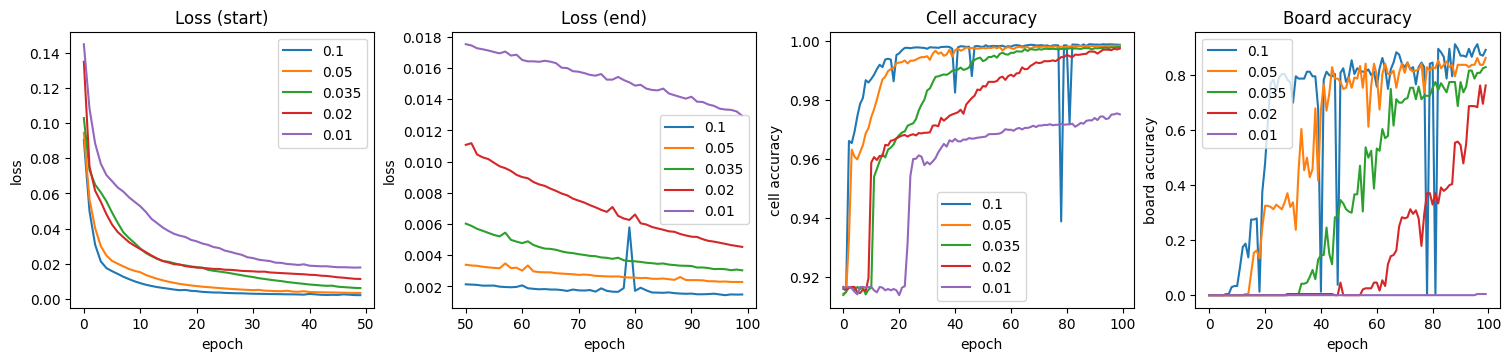

In [14]:
import matplotlib.pyplot as plt

learning_rates = [1e-1, 5e-2, 3.5e-2, 2e-2, 1e-2]
batch_size = 4
epochs = 100

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

fig, axs = plt.subplots(1, 4, figsize=(15, 3.5), constrained_layout=True)
axs = axs.flatten()
ax_loss_1, ax_loss_2, ax_acc, ax_acc_board = axs

ax_loss_1.set_title("Loss (start)")
ax_loss_1.set_xlabel("epoch")
ax_loss_1.set_ylabel("loss")

ax_loss_2.set_title("Loss (end)")
ax_loss_2.set_xlabel("epoch")
ax_loss_2.set_ylabel("loss")

ax_acc.set_title("Cell accuracy")
ax_acc.set_xlabel("epoch")
ax_acc.set_ylabel("cell accuracy")

ax_acc_board.set_title("Board accuracy")
ax_acc_board.set_xlabel("epoch")
ax_acc_board.set_ylabel("board accuracy")

for learning_rate in learning_rates:
    model = TetrisModel().to(device)
    loss_fn = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    loss_history = []
    acc_history = []
    board_acc_history = []

    print(f"Training model with learning rate {learning_rate:.2e}")

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        # Since our dataset represents the full set of possible states, we can safely use it for both training and testing
        epoch_loss = train_loop(dataloader, model, loss_fn, optimizer)
        loss_history.append(epoch_loss)
        # No need to plot test loss separately as in our case it's the same as training loss
        test_metrics = test_loop(dataloader, model, loss_fn)
        acc_history.append(test_metrics["acc"])
        board_acc_history.append(test_metrics["acc_board"])

    print("Done!")

    ax_loss_1.plot(loss_history[:epochs//2], label=str(learning_rate))
    ax_loss_2.plot(list(range(epochs//2, epochs)), loss_history[epochs//2:], label=str(learning_rate))
    ax_acc.plot(acc_history, label=str(learning_rate))
    ax_acc_board.plot(board_acc_history, label=str(learning_rate))

ax_loss_1.legend()
ax_loss_2.legend()
ax_acc.legend()
ax_acc_board.legend()

plt.plot()

As we can see, varying the learning rate alone doesn't solve the problem. Reducing the learning rate to 0.05 has a clear impact on the loss and accuracy while still not removing the instability. Even reducing it to 0.02 maintains the instability while severely impacting the accuracy. A learning rate of 0.01 fails to achieve a board accuracy much above 0%.

# Batch normalization

In [15]:
class ModelWithFullBatchNormalization(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 10, 3)
        self.norm0 = nn.BatchNorm2d(10)
        self.conv1 = nn.Conv2d(10, 10, 3)
        self.norm1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 10, 1)
        self.norm2 = nn.BatchNorm2d(10)
        self.conv3 = nn.Conv2d(10, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = F.relu(self.conv0(F.pad(x, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x = self.norm0(x)
        x = F.relu(self.conv1(F.pad(x, (1, 1, 1, 1))))
        x = self.norm1(x)
        x = F.relu(self.conv2(x))
        x = self.norm2(x)
        logits = F.log_softmax(self.conv3(x), dim=1)
        return logits

In [19]:
class ModelWithEarlyBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 10, 3)
        self.norm = nn.BatchNorm2d(10)
        self.conv1 = nn.Conv2d(10, 10, 3)
        self.conv2 = nn.Conv2d(10, 10, 1)
        self.conv3 = nn.Conv2d(10, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = F.relu(self.conv0(F.pad(x, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x = self.norm(x)
        x = F.relu(self.conv1(F.pad(x, (1, 1, 1, 1))))
        x = F.relu(self.conv2(x))
        logits = F.log_softmax(self.conv3(x), dim=1)
        return logits

In [20]:
class ModelWithMiddleBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 10, 3)
        self.conv1 = nn.Conv2d(10, 10, 3)
        self.norm = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 10, 1)
        self.conv3 = nn.Conv2d(10, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = F.relu(self.conv0(F.pad(x, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x = F.relu(self.conv1(F.pad(x, (1, 1, 1, 1))))
        x = self.norm(x)
        x = F.relu(self.conv2(x))
        logits = F.log_softmax(self.conv3(x), dim=1)
        return logits

In [21]:
class ModelWithLateBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 10, 3)
        self.conv1 = nn.Conv2d(10, 10, 3)
        self.conv2 = nn.Conv2d(10, 10, 1)
        self.norm = nn.BatchNorm2d(10)
        self.conv3 = nn.Conv2d(10, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = F.relu(self.conv0(F.pad(x, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x = F.relu(self.conv1(F.pad(x, (1, 1, 1, 1))))
        x = F.relu(self.conv2(x))
        x = self.norm(x)
        logits = F.log_softmax(self.conv3(x), dim=1)
        return logits

Training model 'baseline'...
Epoch 1
-------------------------------
loss: 0.809400  [    4/  237]
loss: 0.309836  [   84/  237]
loss: 0.332342  [  164/  237]
Test Error: 
 Accuracy: 91.6%, Board accuracy: 0.0%, Avg loss: 0.268197 

Epoch 2
-------------------------------
loss: 0.243854  [    4/  237]
loss: 0.246523  [   84/  237]
loss: 0.176921  [  164/  237]
Test Error: 
 Accuracy: 95.8%, Board accuracy: 0.0%, Avg loss: 0.116741 

Epoch 3
-------------------------------
loss: 0.095643  [    4/  237]
loss: 0.074645  [   84/  237]
loss: 0.084102  [  164/  237]
Test Error: 
 Accuracy: 96.4%, Board accuracy: 0.0%, Avg loss: 0.077961 

Epoch 4
-------------------------------
loss: 0.102943  [    4/  237]
loss: 0.068518  [   84/  237]
loss: 0.113430  [  164/  237]
Test Error: 
 Accuracy: 96.8%, Board accuracy: 0.0%, Avg loss: 0.066539 

Epoch 5
-------------------------------
loss: 0.061145  [    4/  237]
loss: 0.061236  [   84/  237]
loss: 0.076137  [  164/  237]
Test Error: 
 Accuracy: 9

[]

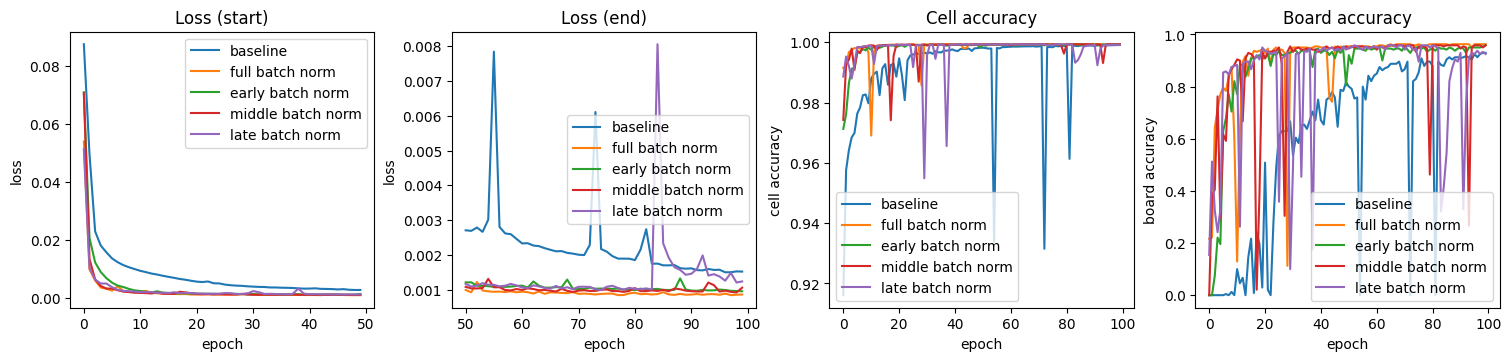

In [23]:
import matplotlib.pyplot as plt

learning_rate = 1e-1
batch_size = 4
epochs = 100

models = {
    "baseline": TetrisModel().to(device),
    "full batch norm": ModelWithFullBatchNormalization().to(device),
    "early batch norm": ModelWithEarlyBatchNorm().to(device),
    "middle batch norm": ModelWithMiddleBatchNorm().to(device),
    "late batch norm": ModelWithLateBatchNorm().to(device),
}

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

fig, axs = plt.subplots(1, 4, figsize=(15, 3.5), constrained_layout=True)
axs = axs.flatten()
ax_loss_1, ax_loss_2, ax_acc, ax_acc_board = axs

ax_loss_1.set_title("Loss (start)")
ax_loss_1.set_xlabel("epoch")
ax_loss_1.set_ylabel("loss")

ax_loss_2.set_title("Loss (end)")
ax_loss_2.set_xlabel("epoch")
ax_loss_2.set_ylabel("loss")

ax_acc.set_title("Cell accuracy")
ax_acc.set_xlabel("epoch")
ax_acc.set_ylabel("cell accuracy")

ax_acc_board.set_title("Board accuracy")
ax_acc_board.set_xlabel("epoch")
ax_acc_board.set_ylabel("board accuracy")

for name, model in models.items():
    loss_fn = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    loss_history = []
    acc_history = []
    board_acc_history = []

    print(f"Training model '{name}'...")

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        # Since our dataset represents the full set of possible states, we can safely use it for both training and testing
        epoch_loss = train_loop(dataloader, model, loss_fn, optimizer)
        loss_history.append(epoch_loss)
        # No need to plot test loss separately as in our case it's the same as training loss
        test_metrics = test_loop(dataloader, model, loss_fn)
        acc_history.append(test_metrics["acc"])
        board_acc_history.append(test_metrics["acc_board"])

    print("Done!")

    ax_loss_1.plot(loss_history[:epochs//2], label=name)
    ax_loss_2.plot(list(range(epochs//2, epochs)), loss_history[epochs//2:], label=name)
    ax_acc.plot(acc_history, label=name)
    ax_acc_board.plot(board_acc_history, label=name)

ax_loss_1.legend()
ax_loss_2.legend()
ax_acc.legend()
ax_acc_board.legend()

plt.plot()

It looks like adding batch normalization does not substantially reduce the instability, but it does speed up training significantly. Even adding a single batch normalization layer is a huge improvement. Batch normalization in the middle of the network seems to be the best option: it improves training time almost as much as batch normalization at all layers, and seems to reduce instability slightly.

# Batch size

According to sources online, loss is not guaranteed to descrease between epochs in stochastic gradient descent, even though it should decrease every epoch for batch gradient descent with appropriately chosen learning rate. Since increasing the minibatch size gets us "closer" to batch gradient descent, it stands to reason that it could reduce training instability.

Training model with batch size 2
Epoch 1
-------------------------------
loss: 0.592904  [    2/  237]
loss: 0.272117  [   42/  237]
loss: 0.246733  [   82/  237]
loss: 0.215098  [  122/  237]
loss: 0.133138  [  162/  237]
loss: 0.073774  [  202/  237]
Test Error: 
 Accuracy: 91.6%, Board accuracy: 0.0%, Avg loss: 0.133353 

Epoch 2
-------------------------------
loss: 0.113289  [    2/  237]
loss: 0.089927  [   42/  237]
loss: 0.092476  [   82/  237]
loss: 0.160578  [  122/  237]
loss: 0.194420  [  162/  237]
loss: 0.050419  [  202/  237]
Test Error: 
 Accuracy: 96.3%, Board accuracy: 0.0%, Avg loss: 0.088078 

Epoch 3
-------------------------------
loss: 0.051344  [    2/  237]
loss: 0.092790  [   42/  237]
loss: 0.083330  [   82/  237]
loss: 0.079966  [  122/  237]
loss: 0.102024  [  162/  237]
loss: 0.031348  [  202/  237]
Test Error: 
 Accuracy: 96.9%, Board accuracy: 0.0%, Avg loss: 0.071914 

Epoch 4
-------------------------------
loss: 0.064976  [    2/  237]
loss: 0.042867 

[]

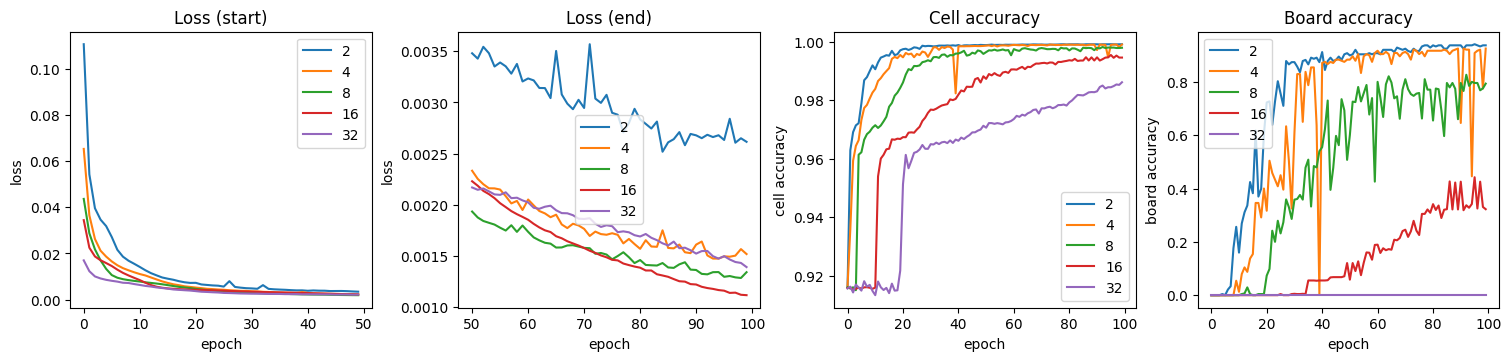

In [29]:
learning_rates = 1e-1
batch_sizes = [2, 4, 8, 16, 32]
epochs = 100

fig, axs = plt.subplots(1, 4, figsize=(15, 3.5), constrained_layout=True)
axs = axs.flatten()
ax_loss_1, ax_loss_2, ax_acc, ax_acc_board = axs

ax_loss_1.set_title("Loss (start)")
ax_loss_1.set_xlabel("epoch")
ax_loss_1.set_ylabel("loss")

ax_loss_2.set_title("Loss (end)")
ax_loss_2.set_xlabel("epoch")
ax_loss_2.set_ylabel("loss")

ax_acc.set_title("Cell accuracy")
ax_acc.set_xlabel("epoch")
ax_acc.set_ylabel("cell accuracy")

ax_acc_board.set_title("Board accuracy")
ax_acc_board.set_xlabel("epoch")
ax_acc_board.set_ylabel("board accuracy")

for batch_size in batch_sizes:
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = TetrisModel().to(device)
    loss_fn = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    loss_history = []
    acc_history = []
    board_acc_history = []

    print(f"Training model with batch size {batch_size}")

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        # Since our dataset represents the full set of possible states, we can safely use it for both training and testing
        epoch_loss = train_loop(dataloader, model, loss_fn, optimizer)
        loss_history.append(epoch_loss)
        # No need to plot test loss separately as in our case it's the same as training loss
        test_metrics = test_loop(dataloader, model, loss_fn)
        acc_history.append(test_metrics["acc"])
        board_acc_history.append(test_metrics["acc_board"])

    print("Done!")

    ax_loss_1.plot(loss_history[:epochs//2], label=str(batch_size))
    ax_loss_2.plot(list(range(epochs//2, epochs)), loss_history[epochs//2:], label=str(batch_size))
    ax_acc.plot(acc_history, label=str(batch_size))
    ax_acc_board.plot(board_acc_history, label=str(batch_size))

ax_loss_1.legend()
ax_loss_2.legend()
ax_acc.legend()
ax_acc_board.legend()

plt.plot()

We see some interesting patterns here. Between batch sizes 2 and 16, loss tends to decrease, but accuracy also decreases! The reason for this could be that we are using cross entropy loss, which depends not only on whether classifications are correct, but also on the confidence of classifications. When loss and accuracy are both lower, it could mean that the model makes more incorrect classifications, but when it is correct, it is more confident and when it is incorrect, it is less confident.

For batch size 32, the loss is high and the accuracy is lower than batch sizes 8 and 16. The reason for this is unclear.

The training instability seems to reduce slightly with larger batch size. The most pronounced reduction in instability is in terms of the loss, but there is benefit for the accuracy as well. Strangely, with batch size 32, the instability seems to return.

These results suggest that if our goal is to increase classification accuracy, we should in fact reduce batch size to 2 rather than increasing it.

To reduce instability, we could:
* Reduce our training data to only include the middle 4 columns of the board, to reduce the imbalance between classes.
  * This means we would be forced to stay with a model architecture that works for variable-size boards. It may also impact some learned features in the future, where those features exhibit differently for different board sizes. For example, detecting when a block has landed through global average pooled spatial features depends on the proportions of certain cell arrangements throughout the board. For larger boards, the change that constitutes a landed block may be less noticeable compared to everything else on the board.
* Use a higher weight for the for the "block" class relative to the "empty" class, if we find that the imbalance between the classes in the datset is significant.
  * The class imbalance is likely to remain for the duration of this project, because most tetris players try to keep the screen relatively empty.
* Use higher weight for cells where the cell type changes, compared to cells where the cell type stays the same. This is because most blocks on the screen will not change between time steps.
  * This imbalance will remain for much of the project, but will be less pronounced once we implement row clearing.
* Try a different loss function which is robust against dataset imbalances (e.g. focal loss)

Another thought: if we want to see why the model occasionally has huge drops in board accuracy, we can take a snapshot of the model weights just before and just after a huge drop in accuracy, then see which predictions the second snapshot gets wrong that the first snapshot gets right.

# Model architecture

Perhaps something about the model architecture, particularly its capacity, is causing the instability. Let's try a few variations of the model architecture to see if it resolves the issue.

In [30]:
class ModelWithNo1x1Conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 10, 3)
        self.conv1 = nn.Conv2d(10, 10, 3)
        self.conv2 = nn.Conv2d(10, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = F.relu(self.conv0(F.pad(x, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x = F.relu(self.conv1(F.pad(x, (1, 1, 1, 1))))
        logits = F.log_softmax(self.conv2(x), dim=1)
        return logits

In [33]:
class ModelWithMoreHiddenFeatures(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 10, 3)
        self.conv1 = nn.Conv2d(10, 20, 3)
        self.conv2 = nn.Conv2d(20, 10, 1)
        self.conv3 = nn.Conv2d(10, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = F.relu(self.conv0(F.pad(x, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x = F.relu(self.conv1(F.pad(x, (1, 1, 1, 1))))
        x = F.relu(self.conv2(x))
        logits = F.log_softmax(self.conv3(x), dim=1)
        return logits

In [35]:
class ModelWithFewerRawFeatures(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 5, 3)
        self.conv1 = nn.Conv2d(5, 10, 3)
        self.conv2 = nn.Conv2d(10, 10, 1)
        self.conv3 = nn.Conv2d(10, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = F.relu(self.conv0(F.pad(x, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x = F.relu(self.conv1(F.pad(x, (1, 1, 1, 1))))
        x = F.relu(self.conv2(x))
        logits = F.log_softmax(self.conv3(x), dim=1)
        return logits

In [37]:
class ModelWithMore1x1ConvFeatures(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 10, 3)
        self.conv1 = nn.Conv2d(10, 10, 3)
        self.conv2 = nn.Conv2d(10, 20, 1)
        self.conv3 = nn.Conv2d(20, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = F.relu(self.conv0(F.pad(x, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x = F.relu(self.conv1(F.pad(x, (1, 1, 1, 1))))
        x = F.relu(self.conv2(x))
        logits = F.log_softmax(self.conv3(x), dim=1)
        return logits

Training model 'baseline'...
Epoch 1
-------------------------------
loss: 0.723381  [    4/  237]
loss: 0.396609  [   84/  237]
loss: 0.282255  [  164/  237]
Test Error: 
 Accuracy: 91.7%, Board accuracy: 0.0%, Avg loss: 0.294545 

Epoch 2
-------------------------------
loss: 0.308508  [    4/  237]
loss: 0.234666  [   84/  237]
loss: 0.243467  [  164/  237]
Test Error: 
 Accuracy: 91.4%, Board accuracy: 0.0%, Avg loss: 0.264955 

Epoch 3
-------------------------------
loss: 0.274109  [    4/  237]
loss: 0.148828  [   84/  237]
loss: 0.195920  [  164/  237]
Test Error: 
 Accuracy: 95.1%, Board accuracy: 0.0%, Avg loss: 0.134808 

Epoch 4
-------------------------------
loss: 0.152850  [    4/  237]
loss: 0.085409  [   84/  237]
loss: 0.072935  [  164/  237]
Test Error: 
 Accuracy: 96.2%, Board accuracy: 0.0%, Avg loss: 0.086806 

Epoch 5
-------------------------------
loss: 0.098511  [    4/  237]
loss: 0.078594  [   84/  237]
loss: 0.076154  [  164/  237]
Test Error: 
 Accuracy: 9

[]

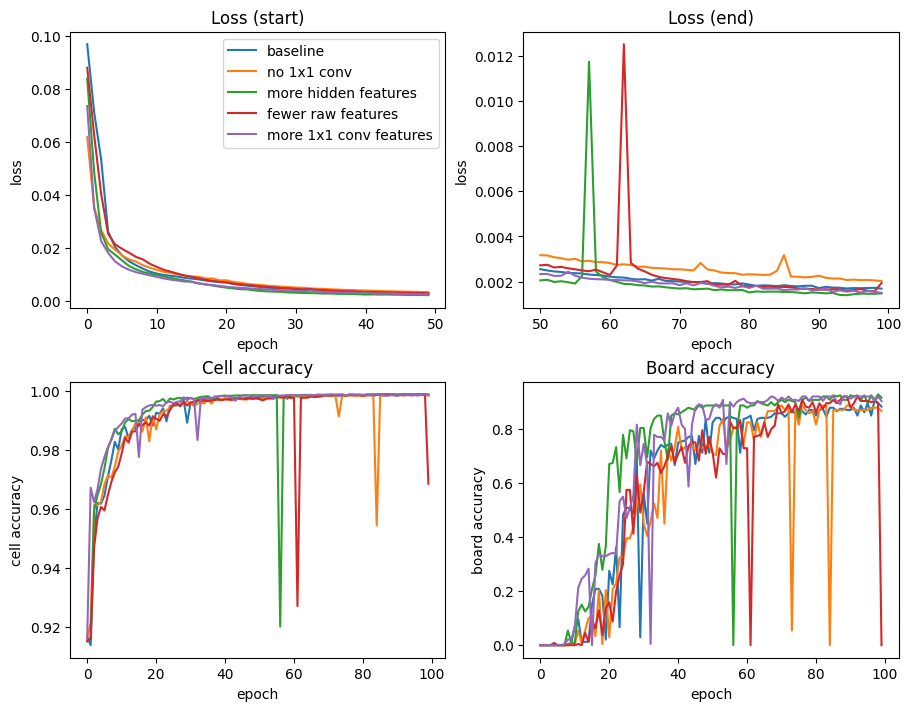

In [44]:
import matplotlib.pyplot as plt

learning_rate = 1e-1
batch_size = 4
epochs = 100

models = {
    "baseline": TetrisModel().to(device),
    "no 1x1 conv": ModelWithNo1x1Conv().to(device),
    "more hidden features": ModelWithMoreHiddenFeatures().to(device),
    "fewer raw features": ModelWithFewerRawFeatures().to(device),
    "more 1x1 conv features": ModelWithMore1x1ConvFeatures().to(device),
}

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

fig, axs = plt.subplots(2, 2, figsize=(9, 7), constrained_layout=True)
axs = axs.flatten()
ax_loss_1, ax_loss_2, ax_acc, ax_acc_board = axs

ax_loss_1.set_title("Loss (start)")
ax_loss_1.set_xlabel("epoch")
ax_loss_1.set_ylabel("loss")

ax_loss_2.set_title("Loss (end)")
ax_loss_2.set_xlabel("epoch")
ax_loss_2.set_ylabel("loss")

ax_acc.set_title("Cell accuracy")
ax_acc.set_xlabel("epoch")
ax_acc.set_ylabel("cell accuracy")

ax_acc_board.set_title("Board accuracy")
ax_acc_board.set_xlabel("epoch")
ax_acc_board.set_ylabel("board accuracy")

for name, model in models.items():
    loss_fn = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    loss_history = []
    acc_history = []
    board_acc_history = []

    print(f"Training model '{name}'...")

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        # Since our dataset represents the full set of possible states, we can safely use it for both training and testing
        epoch_loss = train_loop(dataloader, model, loss_fn, optimizer)
        loss_history.append(epoch_loss)
        # No need to plot test loss separately as in our case it's the same as training loss
        test_metrics = test_loop(dataloader, model, loss_fn)
        acc_history.append(test_metrics["acc"])
        board_acc_history.append(test_metrics["acc_board"])

    print("Done!")

    ax_loss_1.plot(loss_history[:epochs//2], label=name)
    ax_loss_2.plot(list(range(epochs//2, epochs)), loss_history[epochs//2:], label=name)
    ax_acc.plot(acc_history, label=name)
    ax_acc_board.plot(board_acc_history, label=name)

ax_loss_1.legend() # Just one legend is enough as they're all the same. The loss 1 graph is the least cluttered.

plt.plot()

For the smaller models, we see that the loss is noticeably higher because the models have less capacity to fit to the dataset.

The accuracy instability unfortunately persists with all models. The models which modify the number of 3x3 conv features suffer increased instability in terms of both loss and accuracy. The model with more 1x1 conv features does not introduce loss instability, but maintains accuracy instability.

Overall, there is no clear winner out of these models, so let's keep the same architecture for now. Once we have test data in addition to training data, we will be able to make a more informed assessment between different architectures, because we'll also be able to measure how much they overfit.

Another interesting thing to measure would be accuracy that is weighted in some way, for example by class or by whether the cell type changes from one time step to the next.

# Model snapshots

We're going to train the baseline model, looking out for when the board accuracy drops significantly, and then compare snapshots of the model just before and after the drop.

Training model
Epoch 1
-------------------------------
loss: 0.953799  [    4/  237]
loss: 0.368939  [   84/  237]
loss: 0.211383  [  164/  237]
Test Error: 
 Accuracy: 91.6%, Board accuracy: 0.0%, Avg loss: 0.189107 

Epoch 2
-------------------------------
loss: 0.142470  [    4/  237]
loss: 0.129423  [   84/  237]
loss: 0.090877  [  164/  237]
Test Error: 
 Accuracy: 96.8%, Board accuracy: 0.0%, Avg loss: 0.082785 

Epoch 3
-------------------------------
loss: 0.079296  [    4/  237]
loss: 0.099646  [   84/  237]
loss: 0.091215  [  164/  237]
Test Error: 
 Accuracy: 97.1%, Board accuracy: 0.0%, Avg loss: 0.065946 

Epoch 4
-------------------------------
loss: 0.080848  [    4/  237]
loss: 0.059442  [   84/  237]
loss: 0.058179  [  164/  237]
Test Error: 
 Accuracy: 97.1%, Board accuracy: 0.0%, Avg loss: 0.054027 

Epoch 5
-------------------------------
loss: 0.049074  [    4/  237]
loss: 0.050700  [   84/  237]
loss: 0.048335  [  164/  237]
Test Error: 
 Accuracy: 98.2%, Board ac

[]

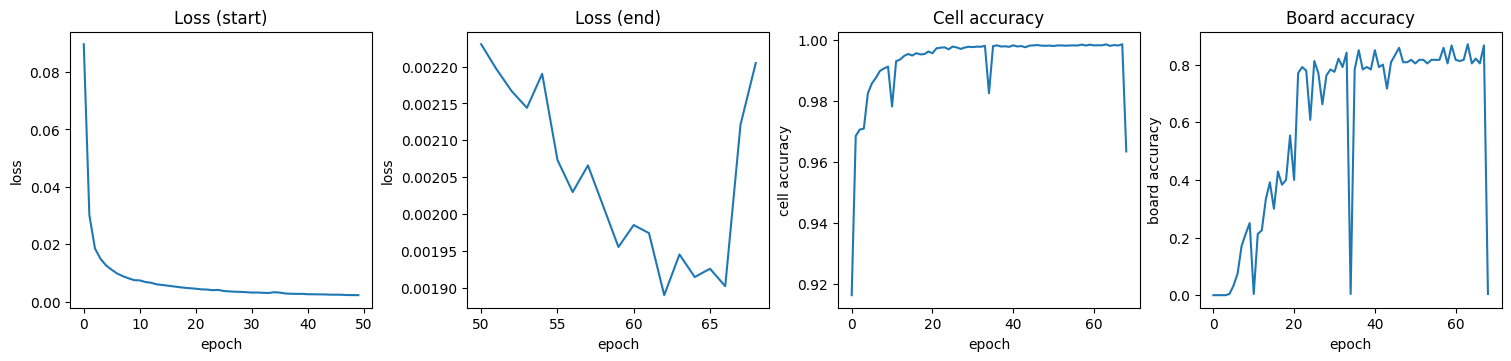

In [72]:
import copy

learning_rates = 1e-1
batch_size = 4
epochs = 100
board_acc_drop_threshold = 0.2

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

fig, axs = plt.subplots(1, 4, figsize=(15, 3.5), constrained_layout=True)
axs = axs.flatten()
ax_loss_1, ax_loss_2, ax_acc, ax_acc_board = axs

ax_loss_1.set_title("Loss (start)")
ax_loss_1.set_xlabel("epoch")
ax_loss_1.set_ylabel("loss")

ax_loss_2.set_title("Loss (end)")
ax_loss_2.set_xlabel("epoch")
ax_loss_2.set_ylabel("loss")

ax_acc.set_title("Cell accuracy")
ax_acc.set_xlabel("epoch")
ax_acc.set_ylabel("cell accuracy")

ax_acc_board.set_title("Board accuracy")
ax_acc_board.set_xlabel("epoch")
ax_acc_board.set_ylabel("board accuracy")

model = TetrisModel().to(device)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss_history = []
acc_history = []
board_acc_history = []

print("Training model")

# First train without any early stopping
for t in range(epochs//2):
    print(f"Epoch {t+1}\n-------------------------------")
    epoch_loss = train_loop(dataloader, model, loss_fn, optimizer)
    loss_history.append(epoch_loss)
    test_metrics = test_loop(dataloader, model, loss_fn)
    acc_history.append(test_metrics["acc"])
    board_acc_history.append(test_metrics["acc_board"])

# Next, take model snapshots and look out for when the board accuracy drops
print("Starting accuracy monitoring")
last_board_acc = board_acc_history[-1]
last_model_state = copy.deepcopy(model.state_dict())
for t in range(epochs//2, epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    epoch_loss = train_loop(dataloader, model, loss_fn, optimizer)
    loss_history.append(epoch_loss)
    test_metrics = test_loop(dataloader, model, loss_fn)
    acc_history.append(test_metrics["acc"])
    board_acc_history.append(test_metrics["acc_board"])
    if board_acc_history[-1] < last_board_acc - board_acc_drop_threshold:
        print(f"Detected board accuracy drop of {(last_board_acc - board_acc_history[-1])*100:.2f}%. Stopping training.")
        model_state = copy.deepcopy(model.state_dict())
        break
    last_board_acc = board_acc_history[-1]
    last_model_state = copy.deepcopy(model.state_dict())
else:
    print("No large accuracy drop detected.")
    raise Exception()

print("Done!")

model_before_drop = TetrisModel().to(device)
model_before_drop.load_state_dict(last_model_state)
model_after_drop = TetrisModel().to(device)
model_after_drop.load_state_dict(model_state)

ax_loss_1.plot(loss_history[:epochs//2])
ax_loss_2.plot(list(range(epochs//2, t+1)), loss_history[epochs//2:])
ax_acc.plot(acc_history)
ax_acc_board.plot(board_acc_history)

plt.plot()

In [76]:
import pandas as pd

correctness = []

for i, (x, y) in enumerate(dataset):
    with torch.no_grad():
        pred_before_drop = model_before_drop(x.unsqueeze(0)).squeeze(0).argmax(0)
        pred_after_drop = model_after_drop(x.unsqueeze(0)).squeeze(0).argmax(0)
        correct_before_drop = (pred_before_drop == y).numpy()
        correct_after_drop = (pred_after_drop == y).numpy()
    num_before = correct_before_drop.astype(np.int32).sum()
    num_after = correct_after_drop.astype(np.int32).sum()
    num_before_not_after = (correct_before_drop & ~correct_after_drop).astype(np.int32).sum()
    num_after_not_before = (~correct_before_drop & correct_after_drop).astype(np.int32).sum()
    num_both = (correct_before_drop & correct_after_drop).astype(np.int32).sum()
    num_neither = (~correct_before_drop & ~correct_after_drop).astype(np.int32).sum()
    correctness.append({
        "Correct before": num_before,
        "Correct after": num_after,
        "Both": num_both,
        "Neither": num_neither,
        "After not before": num_after_not_before,
        "Before not after": num_before_not_after
    })

correctness_df = pd.DataFrame(correctness)

In [78]:
# As expected, the number of correctly predicted cells goes down, and there are a significant number of cells misclassified after the drop but not before the drop.
# There are also a few cells that are misclassified before the drop but not after the drop.
correctness_df.describe()

,Correct before,Correct after,Both,Neither,After not before,Before not after
count,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000
mean,219.679325,211.978903,211.839662,0.181435,0.139241,7.839662
std,0.982104,2.586548,2.653673,0.586567,0.488881,2.565999
min,215.000000,206.000000,206.000000,0.000000,0.000000,0.000000
25%,220.000000,210.000000,210.000000,0.000000,0.000000,7.000000
50%,220.000000,211.000000,211.000000,0.000000,0.000000,8.000000
75%,220.000000,213.000000,213.000000,0.000000,0.000000,10.000000
max,220.000000,220.000000,220.000000,4.000000,3.000000,14.000000


In [102]:
# Let's now find examples of cells that changed from being correctly to incorrectly classified, and vice versa.

cells_correct_before_only = []
cells_correct_after_only = []

for i, (x, y) in enumerate(dataset):
    with torch.no_grad():
        pred_before_drop = model_before_drop(x.unsqueeze(0)).squeeze(0).argmax(0)
        pred_after_drop = model_after_drop(x.unsqueeze(0)).squeeze(0).argmax(0)
        correct_before_drop = (pred_before_drop == y).numpy()
        correct_after_drop = (pred_after_drop == y).numpy()
    # Find cells that were classified correctly by one model and not the other
    correct_before_not_after = correct_before_drop & ~correct_after_drop
    correct_after_not_before = correct_after_drop & ~correct_before_drop
    # Get coordinates of these cells
    coords_before_only = np.argwhere(correct_before_not_after)
    coords_after_only = np.argwhere(correct_after_not_before)
    for coords in coords_before_only:
        x_context = np.pad(x.numpy(), ((2, 2), (2, 2)), constant_values=-1)[coords[0]:coords[0]+5, coords[1]:coords[1]+5] # Pad with -1 to represent past board boundary
        correct_pred = y.numpy()[coords[0], coords[1]]
        cells_correct_before_only.append((x_context, correct_pred))
    for coords in coords_after_only:
        x_context = np.pad(x.numpy(), ((2, 2), (2, 2)), constant_values=-1)[coords[0]:coords[0]+5, coords[1]:coords[1]+5] # Pad with -1 to represent past board boundary
        correct_pred = y.numpy()[coords[0], coords[1]]
        cells_correct_after_only.append((x_context, correct_pred))
    

In [103]:
print("Cells correct only before accuracy drop:", len(cells_correct_before_only))
print("Cells correct only after accuracy drop:", len(cells_correct_after_only))

Cells correct only before accuracy drop: 1858
Cells correct only after accuracy drop: 33


In [109]:
cells_correct_before_only[0][0]

array([[0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

Showing example 1393 correct before accuracy drop
Correct prediction: 0


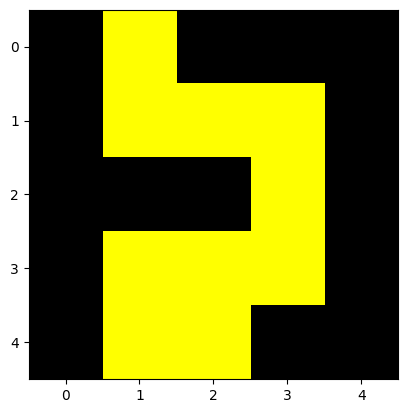

In [248]:
# Show a random prediction that was correct only before the accuracy drop
import random

colours = [np.array([1.0, 0.0, 0.0]), np.array([0.0, 0.0, 0.0]), np.array([1.0, 1.0, 0.0])]

def convert_to_image(arr):
    img = np.zeros((arr.shape[0], arr.shape[1], 3))
    for x in range(arr.shape[0]):
        for y in range(arr.shape[1]):
            col = colours[arr[x, y] + 1]
            for channel in range(3):
                img[x, y, channel] = col[channel]
    return img


idx = random.randrange(len(cells_correct_before_only))
print(f"Showing example {idx} correct before accuracy drop")
ctx, y = cells_correct_before_only[idx]
print(f"Correct prediction: {y}")
img = convert_to_image(ctx)
plt.imshow(img)

Showing example 25 correct after accuracy drop
Correct prediction: 1


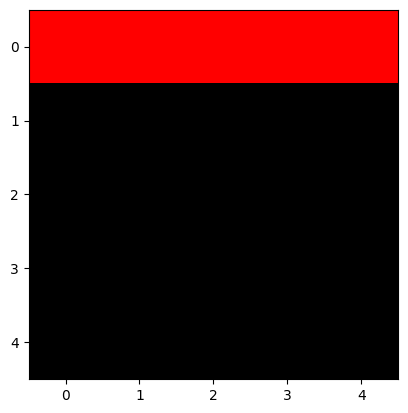

In [275]:
idx = random.randrange(len(cells_correct_after_only))
print(f"Showing example {idx} correct after accuracy drop")
ctx, y = cells_correct_after_only[idx]
print(f"Correct prediction: {y}")
img = convert_to_image(ctx)
plt.imshow(img)

From these visualizations, we make some interesting observations.

The examples that were correct only before the accuracy drop all seem to have 0 as the correct class. The examples that were correct only after the accuracy drop all seem to have 1 as the correct class. This suggests that the large drop in accuracy is due to an overall shift in the model's tendency to predict one class over the other.

The examples that change from correctly to incorrectly classified tend to involve the top boundary when a block is not about to appear, empty cells with a falling block two spaces above them, and empty cells with a stationary block one space above them.

The examples that change from incorrectly to correctly classified tend to involve the top boundary when a block is about to appear, and empty cells with a falling block one space about them.

The fact that many misclassified examples involve the top boundary is likely because the model does not have the capability to identify when a new block is about to appear. Thus, when it encounters a batch with enough examples of a new block appearing, this shifts the model's bias towards predicting 1 near the top boundary where previously it predicted 0. Since most examples in the dataset don't have a new block appearing, this would significantly degrade the overall accuracy on the dataset.

Let's quantify the observations made here.

In [264]:
num_correct_before_only = len(cells_correct_before_only)

class_0_correct_before_only = 0

for x, y in cells_correct_before_only:
    if y == 0:
        class_0_correct_before_only += 1

class_0_correct_before_only_percent = class_0_correct_before_only / num_correct_before_only * 100
print(f"Class 'empty' was the correct class for {class_0_correct_before_only_percent}% ({class_0_correct_before_only}/{num_correct_before_only}) of the examples that were correctly classified only before the accuracy drop.")

Class 'empty' was the correct class for 100.0% (1858/1858) of the examples that were correctly classified only before the accuracy drop.


In [266]:
num_correct_after_only = len(cells_correct_after_only)

class_1_correct_after_only = 0

for x, y in cells_correct_after_only:
    if y == 1:
        class_1_correct_after_only += 1

class_1_correct_after_only_percent = class_1_correct_after_only / num_correct_after_only * 100
print(f"Class 'block' was the correct class for {class_1_correct_after_only_percent}% ({class_1_correct_after_only}/{num_correct_after_only}) of the examples that were correctly classified only after the accuracy drop.")

Class 'block' was the correct class for 100.0% (33/33) of the examples that were correctly classified only after the accuracy drop.


In [290]:
involves_top_boundary_before_only = 0

for x, y in cells_correct_before_only:
    if x[0, 2] == -1:
        involves_top_boundary_before_only += 1

involves_top_boundary_before_only_percent = involves_top_boundary_before_only / num_correct_before_only * 100
print(f"Of 'correct-before-only' examples, {involves_top_boundary_before_only_percent:.2f}% ({involves_top_boundary_before_only}/{num_correct_before_only}) involve the top boundary.")

Of 'correct-before-only' examples, 62.43% (1160/1858) involve the top boundary.


In [284]:
involves_far_above_block_before_only = 0

for x, y in cells_correct_before_only:
    if (x[0, 2] == 1) and (x[1, 2] == 0) and (x[2, 2] == 0):
        involves_far_above_block_before_only += 1

involves_far_above_block_before_only_percent = involves_far_above_block_before_only / num_correct_before_only * 100
print(f"Of 'correct-before-only' examples, {involves_far_above_block_before_only_percent:.2f}% ({involves_far_above_block_before_only}/{num_correct_before_only}) involve an empty cell with an empty cell above it and a block above that.")

Of 'correct-before-only' examples, 13.67% (254/1858) involve an empty cell with an empty cell above it and a block above that.


In [285]:
involves_stationary_block_before_only = 0

for x, y in cells_correct_before_only:
    if (x[1, 2] == 1) and (x[2, 2] == 0):
        involves_stationary_block_before_only += 1

involves_stationary_block_before_only_percent = involves_stationary_block_before_only / num_correct_before_only * 100
print(f"Of 'correct-before-only' examples, {involves_stationary_block_before_only_percent:.2f}% ({involves_stationary_block_before_only}/{num_correct_before_only}) involve an empty cell with a stationary block above it.")

Of 'correct-before-only' examples, 13.40% (249/1858) involve an empty cell with a stationary block above it.


In [289]:
involves_falling_block_before_only = 0

for x, y in cells_correct_before_only:
    if (x[2, 2] == 1):
        involves_falling_block_before_only += 1

involves_falling_block_before_only_percent = involves_falling_block_before_only / num_correct_before_only * 100
print(f"Of 'correct-before-only' examples, {involves_falling_block_before_only_percent:.2f}% ({involves_falling_block_before_only}/{num_correct_before_only}) involve a block falling out of the cell.")

Of 'correct-before-only' examples, 12.49% (232/1858) involve a block falling out of the cell.


This appears to account for all of the 'correct-before-only' examples. In fact, we have some double counting, but it's not substantial so we won't worry too much about why.

In [291]:
involves_top_boundary_after_only = 0

for x, y in cells_correct_after_only:
    if x[0, 2] == -1:
        involves_top_boundary_after_only += 1

involves_top_boundary_after_only_percent = involves_top_boundary_after_only / num_correct_after_only * 100
print(f"Of 'correct-after-only' examples, {involves_top_boundary_after_only_percent:.2f}% ({involves_top_boundary_after_only}/{num_correct_after_only}) involve the top boundary.")

Of 'correct-after-only' examples, 54.55% (18/33) involve the top boundary.


In [295]:
involves_falling_block_after_only = 0

for x, y in cells_correct_after_only:
    if (x[1, 2] == 1) and (x[2, 2] == 0):
        involves_falling_block_after_only += 1

involves_falling_block_after_only_percent = involves_falling_block_after_only / num_correct_after_only * 100
print(f"Of 'correct-after-only' examples, {involves_falling_block_after_only_percent:.2f}% ({involves_falling_block_after_only}/{num_correct_after_only}) involve a block falling into the cell.")

Of 'correct-after-only' examples, 36.36% (12/33) involve a block falling into the cell.


In [298]:
involves_block_cell_after_only = 0

for x, y in cells_correct_after_only:
    if (x[2, 2] == 1):
        involves_block_cell_after_only += 1

involves_block_cell_after_only_percent = involves_block_cell_after_only / num_correct_after_only * 100
print(f"Of 'correct-after-only' examples, {involves_block_cell_after_only_percent:.2f}% ({involves_block_cell_after_only}/{num_correct_after_only}) involve a block cell.")

Of 'correct-after-only' examples, 15.15% (5/33) involve a block cell.


Again, we have double counted slightly, but not by much.

## Hypothesis: Accuracy drops are due to block spawns

Let's make a dataset that explicitly excludes block spawns, and see if that reduces the accuracy instability.

Perhaps when the model encounters too many block spawns towards the end of an epoch then its predictions get biased towards predicting "block" over "empty".

In [299]:
class ListDataset(Dataset):
    def __init__(self, lst):
        self.lst = lst

    def __len__(self):
        return len(self.lst)

    def __getitem__(self, idx):
        return self.lst[idx]

In [312]:
def is_block_spawn(x, y):
    with torch.no_grad():
        no_block_before = torch.all(x[0] == 0).item()
        block_after = torch.any(y[0] == 1).item()
    return no_block_before and block_after

dataset_with_no_block_spawns = [(x, y) for (x, y) in dataset if not is_block_spawn(x, y)]
dataset_with_no_block_spawns = ListDataset(dataset_with_no_block_spawns)
print(len(dataset))
print(len(dataset_with_no_block_spawns))
print(len(dataset) - len(dataset_with_no_block_spawns), "block spawns")

237
228
9 block spawns


Training model with dataset 'baseline'...
Epoch 1
-------------------------------
loss: 0.846516  [    4/  237]
loss: 0.353955  [   84/  237]
loss: 0.281007  [  164/  237]
Test Error: 
 Accuracy: 91.4%, Board accuracy: 0.0%, Avg loss: 0.269044 

Epoch 2
-------------------------------
loss: 0.317543  [    4/  237]
loss: 0.256877  [   84/  237]
loss: 0.198430  [  164/  237]
Test Error: 
 Accuracy: 91.5%, Board accuracy: 0.0%, Avg loss: 0.156788 

Epoch 3
-------------------------------
loss: 0.187688  [    4/  237]
loss: 0.102249  [   84/  237]
loss: 0.078327  [  164/  237]
Test Error: 
 Accuracy: 96.2%, Board accuracy: 0.0%, Avg loss: 0.086207 

Epoch 4
-------------------------------
loss: 0.071948  [    4/  237]
loss: 0.050872  [   84/  237]
loss: 0.063620  [  164/  237]
Test Error: 
 Accuracy: 96.4%, Board accuracy: 0.0%, Avg loss: 0.072914 

Epoch 5
-------------------------------
loss: 0.089255  [    4/  237]
loss: 0.048646  [   84/  237]
loss: 0.063916  [  164/  237]
Test Error: 

[]

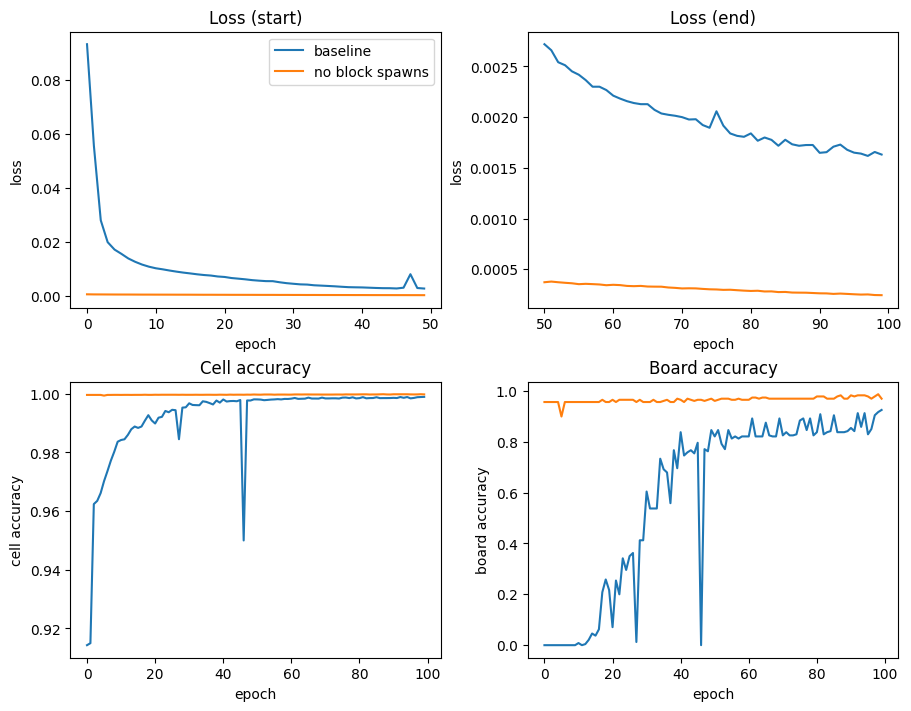

In [305]:
learning_rate = 1e-1
batch_size = 4
epochs = 100
model = TetrisModel().to(device)

datasets = {
    "baseline": dataset,
    "no block spawns": dataset_with_no_block_spawns
}

fig, axs = plt.subplots(2, 2, figsize=(9, 7), constrained_layout=True)
axs = axs.flatten()
ax_loss_1, ax_loss_2, ax_acc, ax_acc_board = axs

ax_loss_1.set_title("Loss (start)")
ax_loss_1.set_xlabel("epoch")
ax_loss_1.set_ylabel("loss")

ax_loss_2.set_title("Loss (end)")
ax_loss_2.set_xlabel("epoch")
ax_loss_2.set_ylabel("loss")

ax_acc.set_title("Cell accuracy")
ax_acc.set_xlabel("epoch")
ax_acc.set_ylabel("cell accuracy")

ax_acc_board.set_title("Board accuracy")
ax_acc_board.set_xlabel("epoch")
ax_acc_board.set_ylabel("board accuracy")

for name, ds in datasets.items():
    dl = DataLoader(ds, batch_size=4, shuffle=True)

    loss_fn = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    loss_history = []
    acc_history = []
    board_acc_history = []

    print(f"Training model with dataset '{name}'...")

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        # Since our dataset represents the full set of possible states, we can safely use it for both training and testing
        epoch_loss = train_loop(dl, model, loss_fn, optimizer)
        loss_history.append(epoch_loss)
        # No need to plot test loss separately as in our case it's the same as training loss
        test_metrics = test_loop(dl, model, loss_fn)
        acc_history.append(test_metrics["acc"])
        board_acc_history.append(test_metrics["acc_board"])

    print("Done!")

    ax_loss_1.plot(loss_history[:epochs//2], label=name)
    ax_loss_2.plot(list(range(epochs//2, epochs)), loss_history[epochs//2:], label=name)
    ax_acc.plot(acc_history, label=name)
    ax_acc_board.plot(board_acc_history, label=name)

ax_loss_1.legend() # Just one legend is enough as they're all the same. The loss 1 graph is the least cluttered.

plt.plot()

As we can see, training without block spawns is much faster and the instability is reduced significantly!

# Conclusion

We have explored several ways to reduce the training instability. By far the most successful of these was removing the block spawns from the dataset. There are only 9 block spawns, accounting for 3.8% of the 237 total examples, so it is not much of a reduction dataset size to take them out. Perhaps when the model has elements that can predict block landings and spawns, these examples will be less problematic.

In our investigations, we have also noted that batch normalization has great potential to speed up training. We will keep this in mind for the future, but will focus on pruning the dataset at present. If we decide to add batch normalization after the dataset change, we should briefly examine whether batch normalization still has the same effect after this change.